### Imports and utils

In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade 'jax[cuda]' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q tensorflow-datasets
!pip install -q git+https://www.github.com/google/neural-tangents

In [1]:
from jax import jit, grad, random, vmap

import jax.numpy as np
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

import tensorflow_datasets as tfds

import matplotlib_inline
import matplotlib.pyplot as plt
import functools

legend = functools.partial(plt.legend, fontsize=10)
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

import seaborn as sns

from utils.data_preparation import preprocess_data
from utils.viz import format_plot, finalize_plot, plot_fn, plot_interpolation
from utils.utils import loss_fn, interpolate_points, choose_random_idxs

%load_ext autoreload
%autoreload 2

In [2]:
# Set random state
key = random.PRNGKey(101)

Create MNIST data pipeline using TensorFlow datasets.

In [3]:
dataset_size = 64

ds_train, ds_test = tfds.as_numpy(
    tfds.load('mnist:3.*.*', split=['train[:%d]' % dataset_size,
                                    'test[:%d]' % dataset_size],
              batch_size=-1)
)

x_train, y_train = ds_train["image"], ds_train["label"]

samples = x_train.shape[0]
x_train = np.array(np.reshape(x_train, (samples, -1)), dtype=np.float32)
train_data = np.hstack((x_train, y_train.reshape(-1, 1)))

x_test, y_test = ds_test["image"], ds_test["label"]
x_test = np.array(np.reshape(x_test, (samples, -1)), dtype=np.float32)
test_data = np.hstack((x_test, y_test.reshape(-1, 1)))

x_train, x_test, y_train, y_test = preprocess_data(train_data, test_data, to_continuous=True)

train = (x_train, y_train)
test = (x_test, y_test)

In [4]:
# Select two random points of the training set
key, subkey = random.split(key)
idx = random.choice(subkey, dataset_size, shape=(2, ), replace=False)

In [5]:
alphas = np.linspace(-3.5, 3.5, 1000)
interpolated_points = interpolate_points(x_train[idx[0]], x_train[idx[1]], alphas[:, np.newaxis])

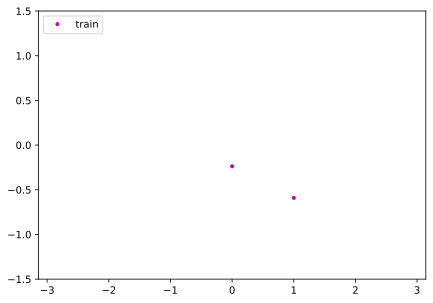

In [6]:
x_train_interpolation = x_train[idx]
y_train_interpolation = y_train[idx]

train_interpolation = (x_train_interpolation, y_train_interpolation)

plot_interpolation(train_interpolation, None)
legend(loc='upper left')
finalize_plot((0.85, 0.6))
plt.savefig('figures/neural_tangents_dynamics_MNIST/fn_plot.png')

### Defining a neural network

In [7]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, 1., 0.05), stax.Erf(),
    stax.Dense(512, 1., 0.05), stax.Erf(),
    stax.Dense(1, 1., 0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

In [8]:
prior_draws = []
for _ in range(10):
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, 784))  # 784 pixels
    prior_draws += [apply_fn(params, interpolated_points)]

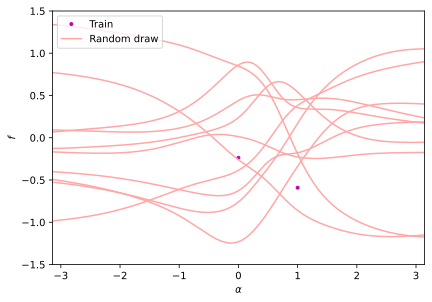

In [9]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')
for p in prior_draws:
    plt.plot(alphas, p, linewidth=1.5, color=[1, 0.65, 0.65])

legend(['Train', 'Random draw'], loc='upper left')

finalize_plot((0.85, 0.6))
plt.savefig('figures/neural_tangents_dynamics_MNIST/random_draws')

In [10]:
kernel = kernel_fn(interpolated_points, interpolated_points, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

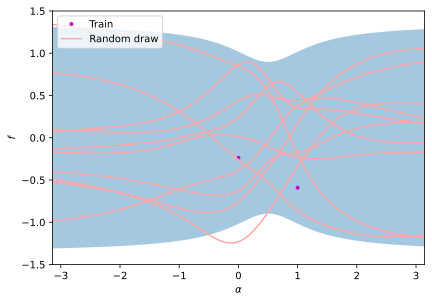

In [11]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.fill_between(alphas, 2 * std_dev, -2 * std_dev, alpha=0.4, label='_nolegend_')

for p in prior_draws:
    plt.plot(alphas, p, linewidth=1.5, color=[1, 0.65, 0.65])

legend(['Train', 'Random draw'], loc='upper left')
finalize_plot((0.85, 0.6))
plt.savefig("figures/neural_tangents_dynamics_MNIST/prior_over_functions.png")

### Infinite width inference

In [12]:
# Note predictor is based not just in the two selected random points but the training set.
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train, y_train, diag_reg=1e-4)
nngp_mean, nngp_covariance = predict_fn(x_test=interpolated_points, get='nngp', compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1, ))
nngp_std = np.sqrt(np.diag(nngp_covariance))

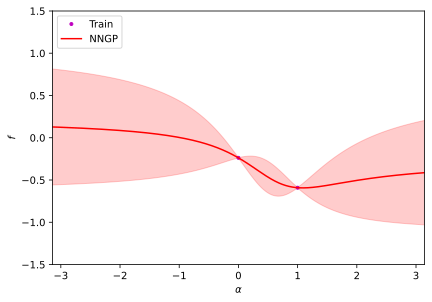

In [13]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.plot(alphas, nngp_mean, 'r-', linewidth=1.5)
plt.fill_between(
    alphas,
    nngp_mean - 2 * nngp_std,
    nngp_mean + 2 * nngp_std,
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'NNGP'], loc='upper left')

finalize_plot((0.85, 0.6))
plt.savefig("figures/neural_tangents_dynamics_MNIST/bayesian_inference_nnpg.png")

In [14]:
ntk_mean, ntk_covariance = predict_fn(x_test=interpolated_points, get='ntk', compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1, ))
ntk_std = np.sqrt(np.diag(ntk_covariance))

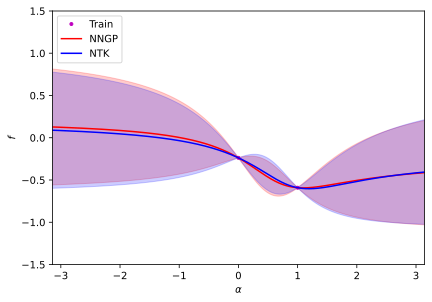

In [15]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.plot(alphas, nngp_mean, 'r-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean + 2 * nngp_std,
    color='red', alpha=0.2, label='_nolegend_')

plt.plot(alphas, ntk_mean, 'b-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean + 2 * ntk_std,
    color='blue', alpha=0.2, label='_nolegend_')

legend(['Train', 'NNGP', 'NTK'],
       loc='upper left')

finalize_plot((0.85, 0.6))
plt.savefig("figures/neural_tangents_dynamics_MNIST/comparison_ntk_nnpg.png")

Inference at different time steps of gradient descent

In [16]:
# Number of steps for gradient descent training
n_plot_time_steps = 9
plot_time_steps = np.array([16 ** i for i in range(n_plot_time_steps + 1)])
plot_time_steps = plot_time_steps.at[0].set(0)

In [17]:
nngp_means, nngp_covariances = predict_fn(x_test=interpolated_points, get='nngp', compute_cov=True, t=plot_time_steps)

nngp_means = np.reshape(nngp_means, (nngp_means.shape[0], -1, ))
nngp_stds = np.sqrt(np.array([np.diag(matrix) for matrix in nngp_covariances]))


ntk_means, ntk_covariances = predict_fn(x_test=interpolated_points, get='ntk', compute_cov=True, t=plot_time_steps)

ntk_means = np.reshape(ntk_means, (ntk_means.shape[0], -1, ))
ntk_stds = np.sqrt(np.array([np.diag(matrix) for matrix in ntk_covariances]))

/Users/juan19.99/Documents/UniHeidelberg/neural-tangents/mathematics_thesis/utils/viz.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


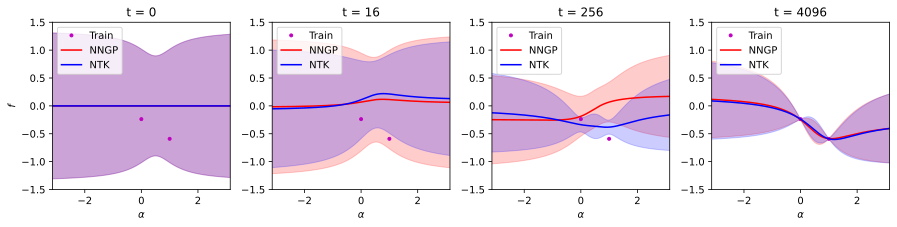

In [18]:
plt.figure(figsize=(10, 5))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    if i == 0:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')
    else:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$')
    
    plt.plot(alphas, nngp_means[i], 'r-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        nngp_means[i] - 2 * nngp_stds[i],
        nngp_means[i] + 2 * nngp_stds[i],
        color='red', alpha=0.2, label='_nolegend_')
    
    plt.plot(alphas, ntk_means[i], 'b-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        ntk_means[i] - 2 * ntk_stds[i],
        ntk_means[i] + 2 * ntk_stds[i],
        color='blue', alpha=0.2, label='_nolegend_')
    
    plt.title('t = {}'.format(plot_time_steps[i]))

    legend(
        ['Train', 'NNGP', 'NTK'],
        loc='upper left')

    finalize_plot((2.3, 0.6))
    
plt.savefig('figures/neural_tangents_dynamics_MNIST/time_step_inference')

### Training a neural network

In [19]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

In [20]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

In [21]:
train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

    train_losses += [loss(get_params(opt_state), *train)]
    test_losses += [loss(get_params(opt_state), *test)]

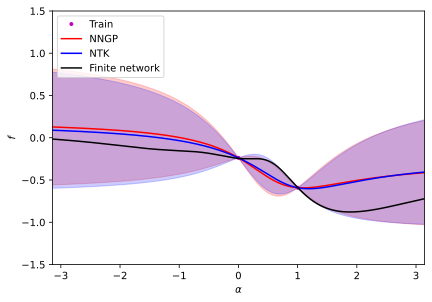

In [22]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.plot(alphas, nngp_mean, 'r-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean + 2 * nngp_std,
    color='red', alpha=0.2, label='_nolegend_')

plt.plot(alphas, ntk_mean, 'b-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean + 2 * ntk_std,
    color='blue', alpha=0.2, label='_nolegend_')

plt.plot(alphas, apply_fn(get_params(opt_state), interpolated_points), 'k-', linewidth=1.5)

legend(
    ['Train', 'NNGP', 'NTK', 'Finite network'],
    loc='upper left')

finalize_plot((0.85, 0.6))
plt.savefig('figures/neural_tangents_dynamics_MNIST/training_dynamics_infinite_finite.png')

### Training an Ensemble of Neural Networks

In [23]:
def train_network(key, ts=None):
    ts_params = []
    train_losses = []
    test_losses = []

    _, params = init_fn(key, (-1, 784))
    opt_state = opt_init(params)

    for i in range(training_steps):
        # Save params for the training steps
        if ts is not None:
            if i in ts:
                ts_params += [get_params(opt_state)]
        
        train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]
        test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
        opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

    train_losses = np.concatenate(train_losses)
    test_losses = np.concatenate(test_losses)
    
    return get_params(opt_state), train_losses, test_losses, ts_params

We can test it to make sure that we get a trained network.

In [24]:
params, train_loss, test_loss, ts_params = train_network(key, ts=plot_time_steps)

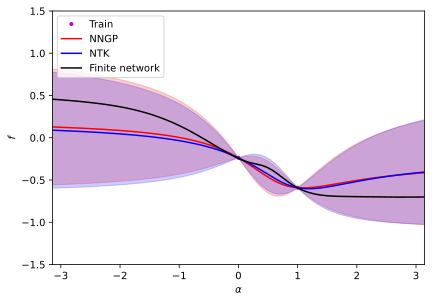

In [25]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.plot(alphas, nngp_mean, 'r-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean + 2 * nngp_std,
    color='red', alpha=0.2, label='_nolegend_')

plt.plot(alphas, ntk_mean, 'b-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean + 2 * ntk_std,
    color='blue', alpha=0.2, label='_nolegend_')

plt.plot(alphas, apply_fn(params, interpolated_points), 'k-', linewidth=1.5)

legend(
    ['Train', 'NNGP', 'NTK', 'Finite network'],
    loc='upper left')

finalize_plot((0.85, 0.6))

/Users/juan19.99/Documents/UniHeidelberg/neural-tangents/mathematics_thesis/utils/viz.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


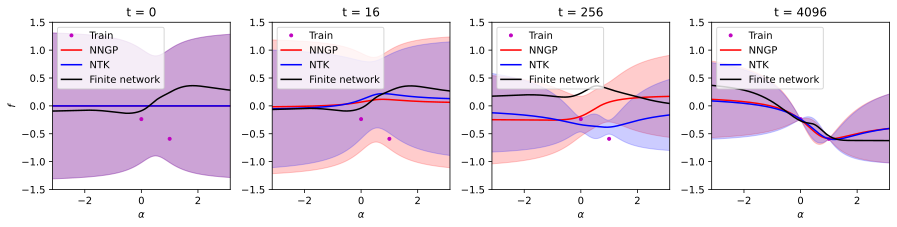

In [26]:
plt.figure(figsize=(10, 5))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    if i == 0:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')
    else:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$')
    
    plt.plot(alphas, nngp_means[i], 'r-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        nngp_means[i] - 2 * nngp_stds[i],
        nngp_means[i] + 2 * nngp_stds[i],
        color='red', alpha=0.2, label='_nolegend_')
    
    plt.plot(alphas, ntk_means[i], 'b-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        ntk_means[i] - 2 * ntk_stds[i],
        ntk_means[i] + 2 * ntk_stds[i],
        color='blue', alpha=0.2, label='_nolegend_')
    
    plt.plot(alphas, apply_fn(ts_params[i], interpolated_points), 'k-', linewidth=1.5)
    
    plt.title('t = {}'.format(plot_time_steps[i]))

    legend(
        ['Train', 'NNGP', 'NTK', 'Finite network'],
        loc='upper left')

    finalize_plot((2.3, 0.6))

In [27]:
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss, ts_params = vmap(train_network, in_axes=(0, None))(ensemble_key, plot_time_steps)

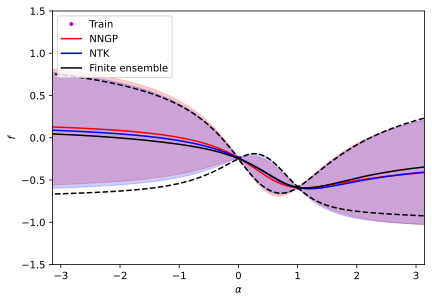

In [28]:
plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')

plt.plot(alphas, nngp_mean, 'r-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean + 2 * nngp_std,
    color='red', alpha=0.2, label='_nolegend_')

plt.plot(alphas, ntk_mean, 'b-', linewidth=1.5)
plt.fill_between(
    np.reshape(alphas, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean + 2 * ntk_std,
    color='blue', alpha=0.2, label='_nolegend_')

ensemble_fx = vmap(apply_fn, (0, None))(params, interpolated_points)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(alphas, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(alphas, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(alphas, mean_fx, linewidth=1.5, color='black')

legend(['Train', 'NNGP', 'NTK', 'Finite ensemble'], loc='upper left')

finalize_plot((0.85, 0.6))

plt.savefig('figures/neural_tangents_dynamics_MNIST/training_dynamics_comparison_ensemble')

/Users/juan19.99/Documents/UniHeidelberg/neural-tangents/mathematics_thesis/utils/viz.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


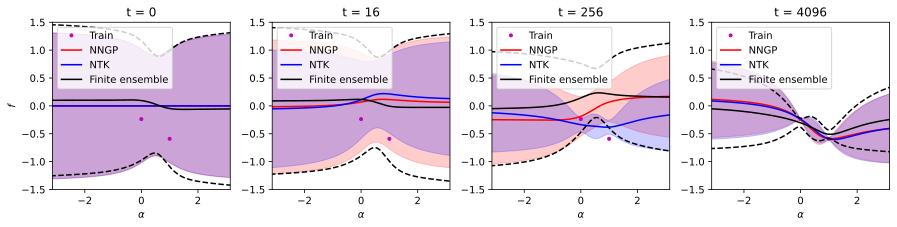

In [30]:
plot_neural_network_outputs = False

plt.figure(figsize=(10, 5))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    if i == 0:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$', ylabel=r'$f$')
    else:
        plot_interpolation(train_interpolation, None, xlabel=r'$\alpha$')
    
    plt.plot(alphas, nngp_means[i], 'r-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        nngp_means[i] - 2 * nngp_stds[i],
        nngp_means[i] + 2 * nngp_stds[i],
        color='red', alpha=0.2, label='_nolegend_')
    
    plt.plot(alphas, ntk_means[i], 'b-', linewidth=1.5)
    plt.fill_between(
        np.reshape(alphas, (-1)),
        ntk_means[i] - 2 * ntk_stds[i],
        ntk_means[i] + 2 * ntk_stds[i],
        color='blue', alpha=0.2, label='_nolegend_')
    
    ensemble_fx = vmap(apply_fn, (0, None))(ts_params[i], interpolated_points)
    
    # Plot neural network outputs
    if plot_neural_network_outputs:
        for k in range(ensemble_size):
            plt.plot(alphas, ensemble_fx[k], linewidth=1, label='_nolegend_')
    
    mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
    std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

    plt.plot(alphas, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
    plt.plot(alphas, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
    plt.plot(alphas, mean_fx, linewidth=1.5, color='black')
    
    plt.title('t = {}'.format(plot_time_steps[i]))

    legend(['Train', 'NNGP', 'NTK', 'Finite ensemble'], loc='upper left')
    finalize_plot((2.3, 0.6))

if plot_neural_network_outputs:
    plt.savefig('figures/neural_tangents_dynamics_MNIST/time_step_inference_ensemble_w_nnoutputs')
else:
    plt.savefig('figures/neural_tangents_dynamics_MNIST/time_step_inference_ensemble')